In [37]:
#imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats #filters
import scipy.fftpack #fft
from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences

np.random.seed(1)

In [77]:
#find files
#function to define path
folder = "data_text_files/"
rats = os.listdir(folder)
rats = list(filter(lambda x: x!=".DS_Store", rats))
print(rats)





#functions

def findfiles(rat, freq):
    path = folder + rat + "/"
    file = path + str(freq) +'.txt'
    return(file)

def skiplines(row_text, file_x):
    line = 0
    fh = open(file_x, "r")
    while True:
        if fh.readline().startswith(row_text):
            break
        line += 1
    return(line)

#filter function

#signal processing 
fs = 1/ .000025 #micro seconds
N = 1024 
T = 1.0 / fs 
nyquist = fs/2
x = np.linspace(0.0, N//fs, N)
xf = np.linspace(0.0, nyquist , N//2)



#set high and low pass values
high = 100/nyquist
low = 1500/nyquist

def bandfilter(raw, h, l):
    b, a = scipy.signal.butter(3, [h, l], 'band')
    filt = scipy.signal.filtfilt(b, a, raw)
    return(filt)



#load files into pandas data frame
df_all = pd.DataFrame([])

freqs = [0, 2000, 4000, 8000, 16000, 24000, 32000]
# dbs = [90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15] --> read from file some stop at 20, 15 or 10 sometimes

f = 0

for rat in rats:
    i = 0
    #find file
    for i in range(7):
        file = findfiles(rat, i)
        print(file)

        #check line index for intensity
        line = skiplines("Intensity", file)

        #open file
        dbs = (pd.io.parsers.read_csv(file, skiprows = line-1, header=None))[1:2].dropna(axis = 1)
        dbs = np.array(dbs)[:,1:].astype('int')

        # find abr data
        line = skiplines('Data', file)
        data = pd.io.parsers.read_csv(file, skiprows=line)
    
        #Keeping only the column containing the average 
        data = data[[c for c in data.columns if c.startswith('Average(uV):')]]
        data.columns = np.arange(len(data.columns))



        



    #load entries
        d = 0
        print(dbs)

        for d in range(1, (dbs.size -1)):
            db = dbs[:, d]
            index = 0
            filt = bandfilter(data.loc[:,d], high, low)
        
            if dbs[:,d] == 90:
                index = d

            if d < index:
            # left data entry
                new_entry = pd.Series({'ratname':rat,'frequency':freqs[i],'dB':db,'L/R':'L','ABR':data.loc[:,d].to_numpy(), 'filtered':filt})
                df_all = pd.concat([df_all, new_entry], ignore_index=True, axis = 1)

            if d >= index:
                # right data entry
                new_entry = pd.Series({'ratname':rat,'frequency':freqs[i],'dB':db,'L/R':'R','ABR': data.loc[:,d].to_numpy(), 'filtered':filt})
                df_all = pd.concat([df_all, new_entry], ignore_index=True, axis = 1)



    #redesign idea

['R165183_042022', 'R144883_091321', 'R165184_042222', 'R144884_091321', 'R165182_042022', 'R165181_041322', 'R165176_04102022', 'R144863_090921', 'R165185_042222']
data_text_files/R165183_042022/0.txt
[[90 85 80 75 70 65 60 55 50 45 40 35 30 25 20 90 85 80 75 70 65 60 55 50
  45 40 35 30 25 20]]
data_text_files/R165183_042022/1.txt
[[90 85 80 75 70 65 60 55 50 45 40 35 30 25 20 90 85 80 75 70 65 60 55 50
  45 40 35 30 25 20]]
data_text_files/R165183_042022/2.txt
[[90 85 80 75 70 65 60 55 50 45 40 35 30 25 20 15 90 85 80 75 70 65 60 55
  50 45 40 35 30 25 20 15]]
data_text_files/R165183_042022/3.txt
[[90 85 80 75 70 65 60 55 50 45 40 35 30 25 20 15 90 85 80 75 70 65 60 55
  50 45 40 35 30 25 20 15]]
data_text_files/R165183_042022/4.txt
[[90 85 80 75 70 65 60 55 50 45 40 35 30 25 20 15 10 90 85 80 75 70 65 60
  55 50 45 40 35 30 25 20 15]]
data_text_files/R165183_042022/5.txt
[[90 85 80 75 70 65 60 55 70 45 40 35 30 25 20 15 10 90 85 80 75 40 60 55
  50 45 35 30 25 20 15 65 50]]
data_te

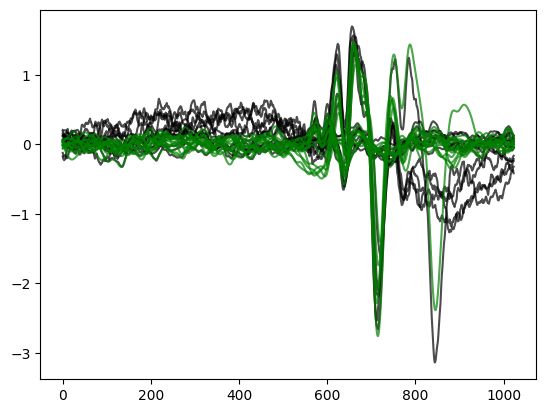

In [97]:
#visualize filter

fi = (df_all.loc['filtered'])
ra = df_all.loc['ABR']



def filt_plot(min, max, c):
    for w in range(min, max):
        plt.plot(fi[w], c,  alpha = .7)

def ra_plot(min, max, c):
    for w in range(min, max):
        plt.plot(ra[w], c, alpha = .7)



ra_plot(200, 214, 'black')
filt_plot(200, 214, 'g')






In [ ]:
# print(df_all)

In [ ]:
#calculate noise floor
#determine threshold

# ONLY signal is present data as input for find peaks 

In [ ]:
#find peaks

#select peaks of interest

In [ ]:
#peak prominencces to detect node to peak (amplitude)
#find node latency